# The Strategy

___
## I. General Condition: The stock price is above its 200-day Moving average

- ### Buy decision if:
    - #### 10 period RSI of the stock is below 30
    - #### -> Buy on the next's day open

- ### Sell decision if:
    - #### 10 period RSI is above 40 OR after 10 trading days
    - #### -> Sell on the next day's open



___
## II. RSI Calculation

- ### Step 1: Calculating Up and Down Moves
    - #### Up moves:
        - ##### -> Take the daily return if return is positive
        - ##### -> Take 0 if return is negative or zero
      
    - #### Down moves:
        - ##### -> Absolute value of daily return if return is negative
        - ##### -> Zero if return is positive or zeros
     
- ### Step 2: Averaging Up and Downmoves
    - #### 1.Pick an average mothod:
        - ##### -> Using Simple Moving Average or Exponential moving average
      
    - #### 2. Using Wilder's smoothing Method which is the same as an exponential moving average but a different smoothing factor
        - ##### The Smoothing factor in exponential moving average: a = 2 / ( N + 1 )
        - ##### The Smoothing factor in WSM: a = 1 / N
        - ##### Because of there is no WSM function in Python to get the WSM alpha of 1/10 we would have to use a N of 19 in exponential moving average formula.

- ### Step 3: RS and RSI calculation
    - #### 1. RS -> Average Up Move / Average Down Move      
    - #### 2. RSI -> 100 - 100 / ( 1 + RS )

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = tickers.Symbol.to_list()

In [3]:
tickers = [i.replace('.','-') for i in tickers]

In [4]:
tickers

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BK',
 'BBWI',
 'BAX',
 'BDX',
 'BRK-B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF-B',
 'BLDR',
 'BG',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'COR',
 'CNC',
 'CNP',
 'CF',
 'CHRW',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA'

In [5]:
tickers[420]

'SOLV'

In [6]:
def RSIcalc(asset):
    df = yf.download(asset, start='2010-01-01')
    df['MA200'] = df['Adj Close'].rolling(window=200).mean()
    df['price change'] = df['Adj Close'].pct_change()
    df['Upmove'] = df['price change'].apply(lambda x: x if x > 0 else 0)
    df['Downmove'] = df['price change'].apply(lambda x: abs(x) if x < 0 else 0)
    # Calculate the average Up in 19 days using exponential moving average
    df['avg Up'] = df['Upmove'].ewm(span=19).mean()
    df['avg Down'] = df['Downmove'].ewm(span=19).mean()
    df = df.dropna()
    df['RS'] = df['avg Up'] / df['avg Down']
    df['RSI'] = df['RS'].apply(lambda x: 100 - ( 100 / ( x + 1 )))
    # Using locator function to find the decision buy/sell signal
    df.loc[(df['Adj Close'] > df['MA200']) & (df['RSI'] < 30), 'Buy'] = 'Yes'
    df.loc[(df['Adj Close'] < df['MA200']) | (df['RSI'] > 30), 'Buy'] = 'No'
    return df

In [7]:
def get_signals(df):
    Buying_dates = []
    Selling_dates = []
    for i in range(len(df) - 11):
        if "Yes" in df['Buy'].iloc[i]:
            # append next day because we want to buy in next day
            Buying_dates.append(df.iloc[i+1].name)
            # Define selling Date as we have to account for the RSI not exceeding 40 over next 10 trading day
            # The 11 is excluded
            for j in range(1,11):
                if df['RSI'].iloc[i + j] > 40:
                    Selling_dates.append(df.iloc[i + j + 1].name)
                    break
                elif j == 10:
                    Selling_dates.append(df.iloc[i + j + 1].name)

    return Buying_dates, Selling_dates

___
#### Testing Usage

In [8]:
frame = RSIcalc(tickers[0]) # 213, 420, 468 Error
buy,sell = get_signals(frame)

[*********************100%%**********************]  1 of 1 completed


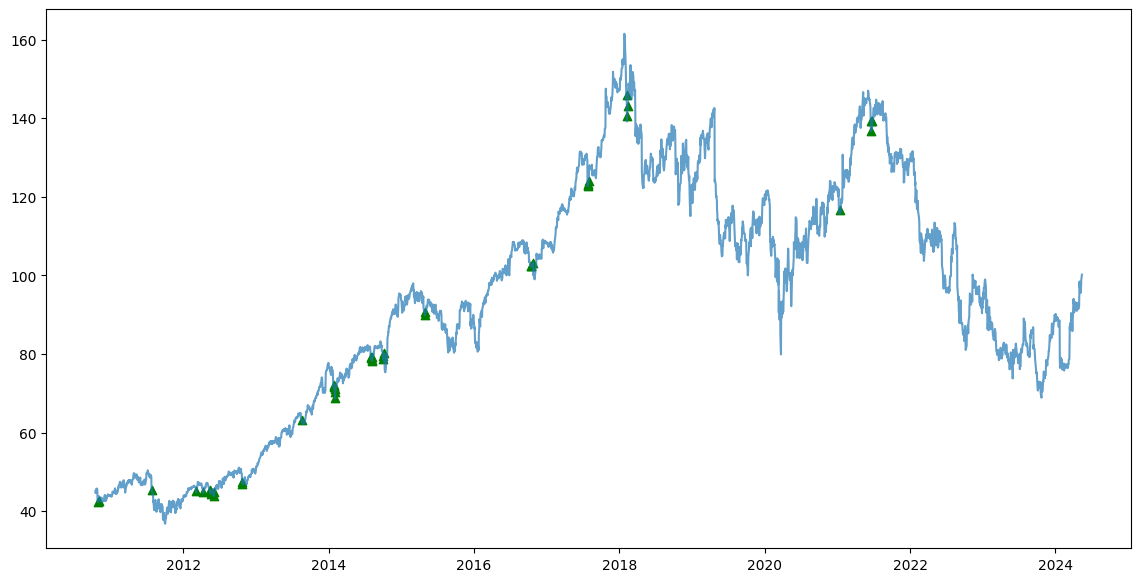

In [9]:
plt.figure(figsize=(14,7))
plt.scatter(frame.loc[buy].index, frame.loc[buy]['Adj Close'], marker = '^', c = 'g')
plt.plot(frame['Adj Close'],alpha=0.7)

In [10]:
Profits = (frame.loc[sell].Open.values - frame.loc[buy].Open.values) / frame.loc[buy].Open.values

# Calculate the winning rate (Find the number of Profit > 0 / number of Profit < 0
wins_time = [i for i in Profits if i > 0]
win_rate = len(wins_time)/len(Profits)

# Number of trade in period
len(Profits)

44

#### Apply for All Companies#### Apply for All Companies

In [11]:
matrix_signals = []
matrix_profits = []

list_error_index = [213, 420, 468]

for i in range(len(tickers)):
    if i in list_error_index:
        print("Error" + str(i))
    else:
        frame = RSIcalc(tickers[i])
        buy, sell = get_signals(frame)
        Profits = (frame.loc[sell].Open.values - frame.loc[buy].Open.values) / frame.loc[buy].Open.values
        matrix_signals.append(buy)
        matrix_profits.append(Profits)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Error213



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Error420



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Error468



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

In [12]:
all_profits = []

for i in matrix_profits:
    for e in i:
        all_profits.append(e)

In [13]:
all_profits

[0.034172896485863,
 0.03124634528287981,
 -0.09688926092834244,
 0.018418539824998234,
 0.01323805788511552,
 -0.011518319049029505,
 -0.01105804475092315,
 0.002123082380676442,
 0.012875500063910276,
 0.03632401932075092,
 0.02847873368300234,
 0.010333635237076089,
 0.015580904503665099,
 0.010122366984655696,
 -0.0034609788599290286,
 0.0010816744966984711,
 -0.004073807139837266,
 0.02345970375248012,
 0.01052876685637078,
 0.02759932878154514,
 0.005565482575232033,
 0.005565482575232033,
 0.012864764808005337,
 0.006283474269166027,
 0.01170136934220926,
 0.018618729158654986,
 0.013062487515922315,
 0.02097651060088746,
 0.01300844967949311,
 0.013202291623673408,
 -0.0007664579988441258,
 0.0035530731521544842,
 -0.018418741366099372,
 0.013669244541192505,
 0.020337382273743952,
 0.011952753223226096,
 0.015949982466781098,
 0.008527080483225827,
 0.021548414260407305,
 0.008615752596016907,
 0.018927131095298533,
 -0.005284569054651168,
 0.014090336408731594,
 0.01120922930

In [14]:
wins = [i for i in all_profits if i > 0]

win_rate = len(wins)/len(all_profits)
print("win_rate: " + str(win_rate  * 100))

win_rate: 70.14773306164035


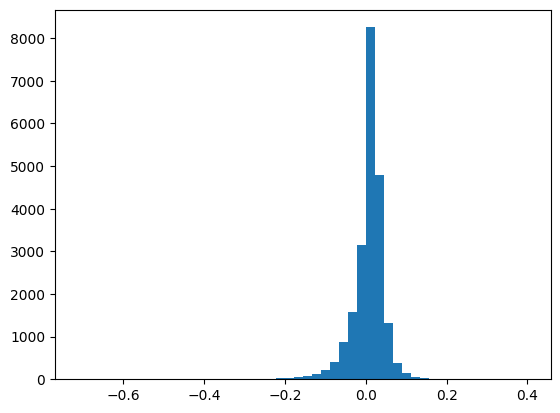

In [15]:
plt.hist(all_profits, bins=50)
plt.show()

In [16]:
for i in matrix_signals:
    for e in i:
        if e.year == 2024:
            print(e)

2024-03-19 00:00:00
2024-03-21 00:00:00
2024-03-22 00:00:00
2024-03-25 00:00:00
2024-03-26 00:00:00
2024-04-18 00:00:00
2024-04-05 00:00:00
2024-04-12 00:00:00
2024-04-15 00:00:00
2024-04-16 00:00:00
2024-04-17 00:00:00
2024-04-29 00:00:00
2024-03-22 00:00:00
2024-03-25 00:00:00
2024-03-26 00:00:00
2024-03-27 00:00:00
2024-01-05 00:00:00
2024-01-08 00:00:00
2024-02-20 00:00:00
2024-02-21 00:00:00
2024-02-22 00:00:00
2024-02-23 00:00:00
2024-04-05 00:00:00
2024-04-18 00:00:00
2024-04-22 00:00:00
2024-04-23 00:00:00
2024-02-02 00:00:00
2024-02-05 00:00:00
2024-02-06 00:00:00
2024-02-07 00:00:00
2024-04-12 00:00:00
2024-04-18 00:00:00
2024-04-19 00:00:00
2024-04-22 00:00:00
2024-01-08 00:00:00
2024-02-15 00:00:00
2024-02-16 00:00:00
2024-02-20 00:00:00
2024-02-21 00:00:00
2024-02-22 00:00:00
2024-02-23 00:00:00
2024-02-26 00:00:00
2024-02-27 00:00:00
2024-02-28 00:00:00
2024-02-29 00:00:00
2024-04-18 00:00:00
2024-04-19 00:00:00
2024-04-22 00:00:00
2024-04-17 00:00:00
2024-01-25 00:00:00
